In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import random
import gc
import math

In [2]:
# 清空 GPU 缓存
torch.cuda.empty_cache()

# 强制进行垃圾回收
gc.collect()

0

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# 设置随机种子
seed = 12
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# 在使用GPU时，还应该设置GPU的随机种子
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [5]:
look_back = 20 #历史时间步
pred_forward = 1 #预测未来时间步
input_sequence_length = 20 #encoder与decoder接收数据长度
output_sequence_length = 1
epochs = 20 #迭代次数
num_features_input = 1 #输入特征数
num_features_output = 1
embed_dim = 16 #嵌入维度
dense_dim = 8 #隐藏层神经元个数
num_heads = 2 #头数
dropout_rate = 0.1 #失活率
num_blocks = 2 #编码器解码器数
learn_rate = 0.001 #学习率
batch_size = 32 #批大小

In [6]:
data = pd.read_csv('RV_STL.csv')

In [7]:
data.tail()

,datetime,realized_volatility,trend,seasonal
6715,2025-09-08 21:00:00,0.004493,0.002993,0.001506
6716,2025-09-08 21:15:00,0.004493,0.002997,0.001042
6717,2025-09-08 21:30:00,0.003248,0.003000,0.000327
6718,2025-09-08 21:45:00,0.001885,0.003004,-0.000843
6719,2025-09-08 22:00:00,0.001750,0.003007,-0.001142


In [8]:
data_used = data[['realized_volatility']]

In [9]:
data_X = data_used.values
data_Y = data_used['realized_volatility'].values

In [10]:
scaler1 = MinMaxScaler(feature_range=(0, 1))
scaler2 = MinMaxScaler(feature_range=(0, 1))

In [11]:
train_size  = int(len(data_X)*0.8)
val_size = int(len(data_X)*0.1)
test_size = len(data_X) - train_size - val_size

In [12]:
train_X,train_Y = data_X[0:train_size], data_Y[0:train_size]
val_X,val_Y = data_X[train_size:train_size+val_size], data_Y[train_size:train_size+val_size]
test_X,test_Y = data_X[train_size+val_size:], data_Y[train_size+val_size:]

In [13]:
scaler1.fit(train_X)  # 使用训练集进行拟合
scaler2.fit(train_Y.reshape(-1, 1))  # 使用训练集进行拟合

train_X = scaler1.transform(train_X)
train_Y = scaler2.transform(train_Y.reshape(-1, 1))

val_X = scaler1.transform(val_X)
val_Y = scaler2.transform(val_Y.reshape(-1, 1))

test_X = scaler1.transform(test_X)
test_Y = scaler2.transform(test_Y.reshape(-1, 1))

In [14]:
# 定义输入数据，输出标签数据的格式的函数，并将数据转换为模型可接受的3D格式
def create_dataset(datasetX, datasetY, look_back = 1, pred_forward = 1):
    dataX, dataY = [], []
    for i in range(0, len(datasetX) - look_back - pred_forward, pred_forward):
        a = datasetX[i:(i + look_back), :]
        dataX.append(a)
        if pred_forward==1:
            dataY.append(datasetY[i + look_back])
        else:
            dataY.append(datasetY[i + look_back:i + look_back + pred_forward,0])
    return np.array(dataX), np.array(dataY)

In [15]:
# 准备训练集和测试集的数据
trainX, trainY = create_dataset(train_X, train_Y, look_back, pred_forward)
valX, valY = create_dataset(val_X,val_Y, look_back, pred_forward)
testX, testY = create_dataset(test_X, test_Y, look_back, pred_forward)

In [16]:
# 转换为PyTorch的Tensor数据
trainX = torch.Tensor(trainX)
trainY = torch.Tensor(trainY)
valX = torch.Tensor(valX)
valY = torch.Tensor(valY)
testX = torch.Tensor(testX)
testY = torch.Tensor(testY)

In [17]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate=0.1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM 层
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)

        # 全连接层，将 LSTM 输出映射到最终输出
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # 前向传播 LSTM
        lstm_out, _ = self.lstm(x)

        # 只取 LSTM 的最后一个时间步的输出
        out = self.fc(lstm_out[:, -1, :])  # 只取最后一个时间步
        return out

    def predict_multi_step(self, input_seq, steps):
        """
        多步预测方法，每次使用上一轮预测的结果拼接在输入序列后，预测下一个时间步的值。
        参数:
        - input_seq: 输入的序列，形状为 (batch_size, seq_length, input_size)
        - steps: 要预测的步数
        返回:
        - predictions: 预测的多步结果，形状为 (batch_size, steps, output_size)
        """
        predictions = []
        current_seq = input_seq.clone()  # 复制一份输入序列以进行多步预测

        for _ in range(steps):
            # 使用模型预测当前序列的下一个时间步
            prediction = self.forward(current_seq)  # 形状 (batch_size, output_size)

            # 将预测的值扩展到 (batch_size, 1, output_size) 以便拼接到序列末尾
            prediction_expanded = prediction.unsqueeze(1)  # 形状 (batch_size, 1, output_size)

            # 将新预测的结果拼接到当前序列末尾，并去掉第一个时间步
            current_seq = torch.cat((current_seq[:, 1:, :], prediction_expanded), dim=1)  # 去掉第一个时间步

            # 记录当前的预测结果
            predictions.append(prediction_expanded)

        # 将所有预测结果拼接为最终的输出，形状为 (batch_size, steps, output_size)
        return torch.cat(predictions, dim=1)

In [18]:
# 定义训练集和测试集的数据加载器
class MyDataset(Dataset):
    def __init__(self, data_X, data_Y):
        self.data_X = data_X
        self.data_Y = data_Y

    def __getitem__(self, index):
        x = self.data_X[index]
        y = self.data_Y[index]
        return x, y

    def __len__(self):
        return len(self.data_X)

In [19]:
train_dataset = MyDataset(trainX, trainY)
val_dataset = MyDataset(valX, valY)
test_dataset = MyDataset(testX, testY)

In [20]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [21]:
model = LSTMModel(num_features_input,embed_dim,2,num_features_output)
model.to(device)

LSTMModel(
  (lstm): LSTM(1, 16, num_layers=2, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [22]:
# 定义损失函数和优化器

from torch.optim.lr_scheduler import ReduceLROnPlateau
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=4)

In [23]:
train_losses = []
val_losses = []
# epochs=25
# 训练模型
for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0  # 初始化训练损失
    for inputs, labels in tqdm(train_loader, position=0, leave=True):
        inputs = inputs.to(device)
        labels = labels.to(device)
#         print(inputs.size())

        optimizer.zero_grad()

        outputs = model(inputs)
        # print(outputs.size())
        # print(labels.size())
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    average_train_loss = running_train_loss / len(train_loader)
    train_losses.append(average_train_loss)

    # 在验证集上计算损失
    model.eval()
    running_val_loss = 0.0  # 初始化验证损失
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, position=0, leave=True):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)

            val_loss = criterion(outputs, labels)
            running_val_loss += val_loss.item()

    average_val_loss = running_val_loss / len(val_loader)
    val_losses.append(average_val_loss)

    # 每个 epoch 打印一次训练和验证损失
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {average_train_loss:.8f}, Val Loss: {average_val_loss:.8f}')
    scheduler.step(average_val_loss)

100%|██████████| 21/21 [00:00<00:00, 1374.71it/s]


Epoch 1/20, Train Loss: 0.00635852, Val Loss: 0.00358005


100%|██████████| 21/21 [00:00<00:00, 1781.20it/s]


Epoch 2/20, Train Loss: 0.00385019, Val Loss: 0.00280552


100%|██████████| 21/21 [00:00<00:00, 2278.39it/s]


Epoch 3/20, Train Loss: 0.00325263, Val Loss: 0.00265197


100%|██████████| 21/21 [00:00<00:00, 1985.98it/s]


Epoch 4/20, Train Loss: 0.00275424, Val Loss: 0.00205459


100%|██████████| 21/21 [00:00<00:00, 2184.05it/s]


Epoch 5/20, Train Loss: 0.00235782, Val Loss: 0.00168380


100%|██████████| 21/21 [00:00<00:00, 1452.97it/s]


Epoch 6/20, Train Loss: 0.00221184, Val Loss: 0.00141168


100%|██████████| 21/21 [00:00<00:00, 1891.88it/s]


Epoch 7/20, Train Loss: 0.00161426, Val Loss: 0.00129551


100%|██████████| 21/21 [00:00<00:00, 2171.23it/s]


Epoch 8/20, Train Loss: 0.00145024, Val Loss: 0.00119738


100%|██████████| 21/21 [00:00<00:00, 2254.77it/s]


Epoch 9/20, Train Loss: 0.00140514, Val Loss: 0.00128856


100%|██████████| 21/21 [00:00<00:00, 2088.95it/s]


Epoch 10/20, Train Loss: 0.00142603, Val Loss: 0.00131591


100%|██████████| 21/21 [00:00<00:00, 1876.77it/s]


Epoch 11/20, Train Loss: 0.00137061, Val Loss: 0.00119314


100%|██████████| 21/21 [00:00<00:00, 2174.18it/s]


Epoch 12/20, Train Loss: 0.00133254, Val Loss: 0.00114626


100%|██████████| 21/21 [00:00<00:00, 1171.30it/s]


Epoch 13/20, Train Loss: 0.00127453, Val Loss: 0.00112886


100%|██████████| 21/21 [00:00<00:00, 2255.75it/s]


Epoch 14/20, Train Loss: 0.00130555, Val Loss: 0.00128222


100%|██████████| 21/21 [00:00<00:00, 389.24it/s]


Epoch 15/20, Train Loss: 0.00126651, Val Loss: 0.00114675


100%|██████████| 21/21 [00:00<00:00, 360.13it/s]


Epoch 16/20, Train Loss: 0.00122203, Val Loss: 0.00110849


100%|██████████| 21/21 [00:00<00:00, 366.78it/s]


Epoch 17/20, Train Loss: 0.00123900, Val Loss: 0.00111552


100%|██████████| 21/21 [00:00<00:00, 334.02it/s]


Epoch 18/20, Train Loss: 0.00120563, Val Loss: 0.00115272


100%|██████████| 21/21 [00:00<00:00, 388.46it/s]


Epoch 19/20, Train Loss: 0.00120579, Val Loss: 0.00109663


100%|██████████| 21/21 [00:00<00:00, 309.60it/s]

Epoch 20/20, Train Loss: 0.00119412, Val Loss: 0.00109300


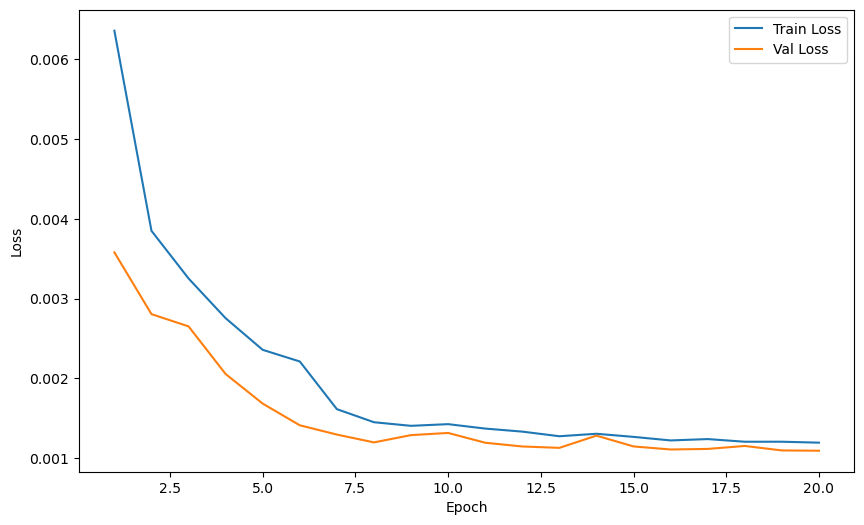

In [24]:
# 可视化损失函数
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
# 测试模型
model.eval()
predictions = []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader ,position=0):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        predictions.extend(outputs.cpu().numpy())

predictions = np.array(predictions).reshape(-1, 1)
labels = (testY.cpu().numpy()).reshape(-1, 1)

#测试集数据反归一化
predictions = scaler2.inverse_transform(predictions)
labels = scaler2.inverse_transform(labels)

100%|██████████| 21/21 [00:00<00:00, 288.82it/s]


In [26]:
# 计算模型的评价指标
r2 = r2_score(labels, predictions)
mae = mean_absolute_error(labels, predictions)
rmse = np.sqrt(mean_squared_error(labels, predictions))
# mape = np.mean(np.abs((labels - predictions) / labels))

# 打印模型的评价指标
print('R^2:', r2)
print('MAE:', mae)
print('RMSE:', rmse)
# print('MAPE:', mape)

R^2: 0.7464768424252376
MAE: 0.00040824586
RMSE: 0.00064478855


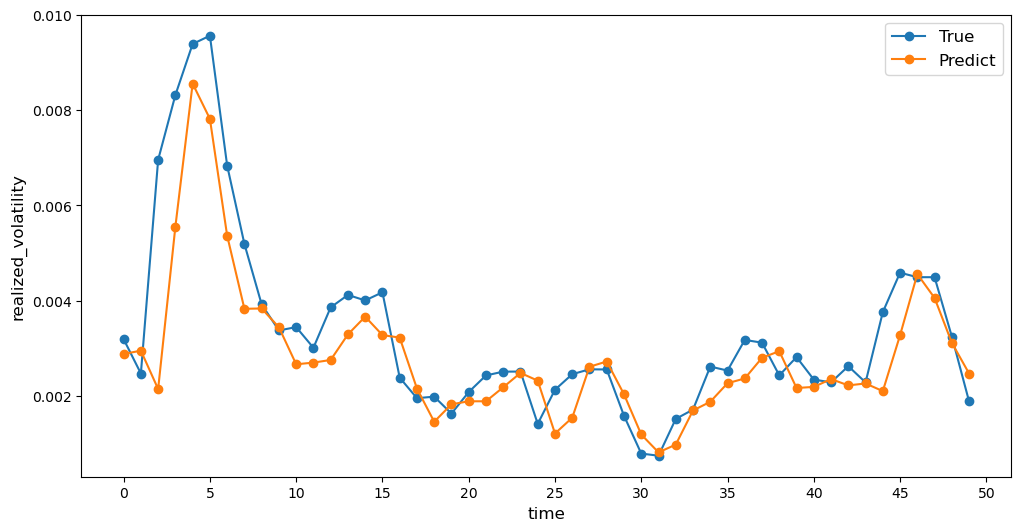

In [27]:
n = 50
labels_subset = labels[-n:]
predictions_subset = predictions[-n:]

plt.figure(figsize=(12, 6))
plt.xlabel('time', fontsize=12)
plt.xticks(ticks=range(0, n + 1,5), labels=range(0,n + 1,5))
plt.ylabel('realized_volatility', fontsize=12)

# # 绘制真实值
# plt.plot(labels_subset, label='True', marker='o', markerfacecolor='none', markeredgecolor='blue', linestyle='-')
# # 绘制预测值
# plt.plot(predictions_subset, label='Predict', marker='o', markerfacecolor='none', markeredgecolor='red', linestyle='-')

plt.plot(labels_subset, label='True', marker='o', linestyle='-')
plt.plot(predictions_subset, label='Predict', marker='o', linestyle='-')

plt.legend(fontsize=12)
plt.show()

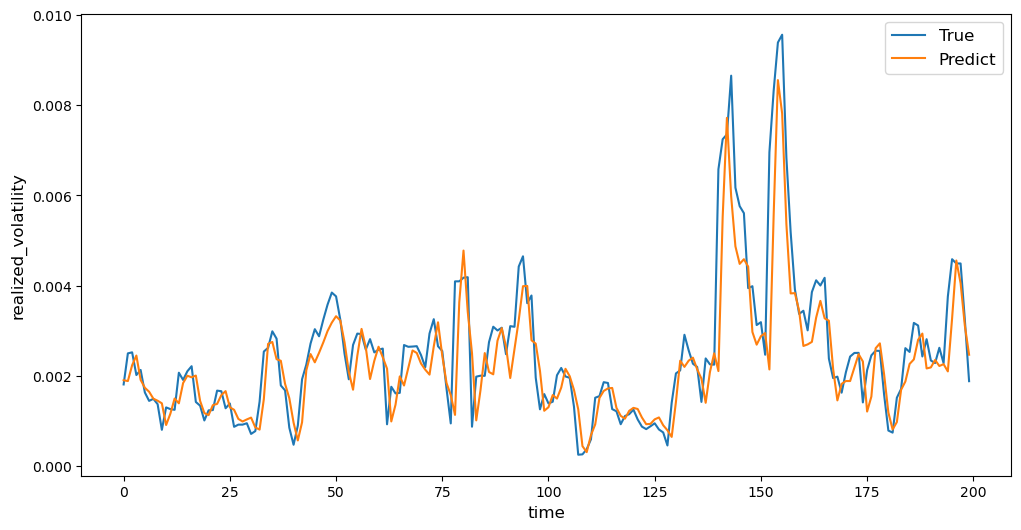

In [28]:
# 假设 labels 和 predictions 是包含所有数据的列表或数组
# 只展示前200条数据
n = 200
labels_subset = labels[-n:]
predictions_subset = predictions[-n:]

plt.figure(figsize=(12, 6))
plt.xlabel('time', fontsize=12)
plt.ylabel('realized_volatility', fontsize=12)
plt.plot(labels_subset, label='True')
plt.plot(predictions_subset, label='Predict')
plt.legend(fontsize=12)
plt.show()

In [29]:
multi_step = 5

In [30]:
testX_multi, testY_multi = create_dataset(test_X, test_Y, look_back, pred_forward=multi_step)

In [31]:
testX_multi = torch.Tensor(testX_multi)
testY_multi = torch.Tensor(testY_multi)

In [32]:
test_dataset_multi = MyDataset(testX_multi, testY_multi)

In [33]:
test_loader_multi = DataLoader(test_dataset_multi, batch_size=batch_size, shuffle=False)

In [34]:
# 测试模型
model.eval()
predictions = []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader_multi ,position=0):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model.predict_multi_step(inputs,steps=multi_step)

        predictions.extend(outputs.cpu().numpy())

predictions = np.array(predictions).reshape(-1, 1)
labels = (testY_multi.cpu().numpy()).reshape(-1, 1)

#测试集数据反归一化
predictions = scaler2.inverse_transform(predictions)
labels = scaler2.inverse_transform(labels)

100%|██████████| 5/5 [00:00<00:00, 104.85it/s]


In [35]:
# 计算模型的评价指标
r2 = r2_score(labels, predictions)
mae = mean_absolute_error(labels, predictions)
rmse = np.sqrt(mean_squared_error(labels, predictions))
# mape = np.mean(np.abs((labels - predictions) / labels))

# 打印模型的评价指标
print('R^2:', r2)
print('MAE:', mae)
print('RMSE:', rmse)
# print('MAPE:', mape)

R^2: 0.26885102636748315
MAE: 0.00070065423
RMSE: 0.0010958235


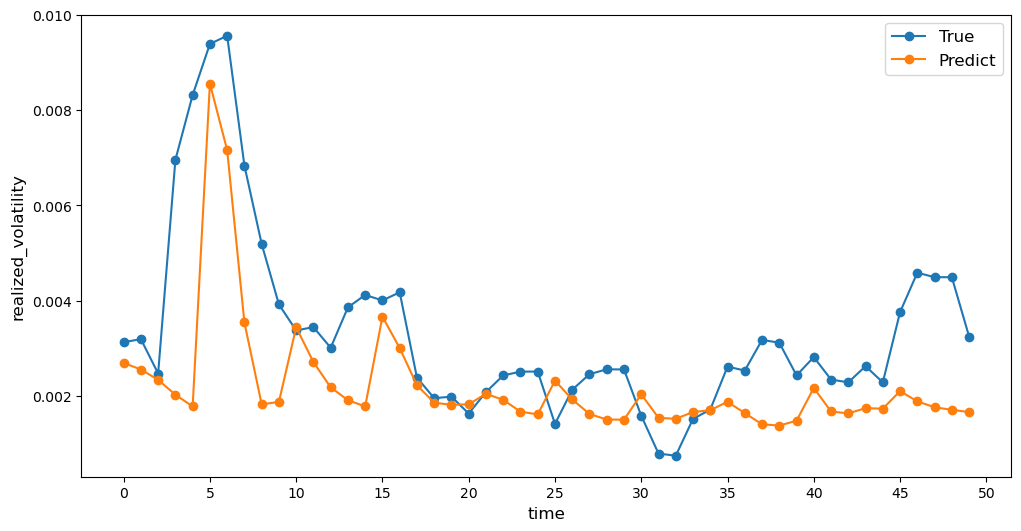

In [36]:
n = 50
labels_subset = labels[-n:]
predictions_subset = predictions[-n:]

plt.figure(figsize=(12, 6))
plt.xlabel('time', fontsize=12)
plt.xticks(ticks=range(0, n + 1,5), labels=range(0,n + 1,5))
plt.ylabel('realized_volatility', fontsize=12)

# # 绘制真实值
# plt.plot(labels_subset, label='True', marker='o', markerfacecolor='none', markeredgecolor='blue', linestyle='-')
# # 绘制预测值
# plt.plot(predictions_subset, label='Predict', marker='o', markerfacecolor='none', markeredgecolor='red', linestyle='-')

plt.plot(labels_subset, label='True', marker='o', linestyle='-')
plt.plot(predictions_subset, label='Predict', marker='o', linestyle='-')

plt.legend(fontsize=12)
plt.show()

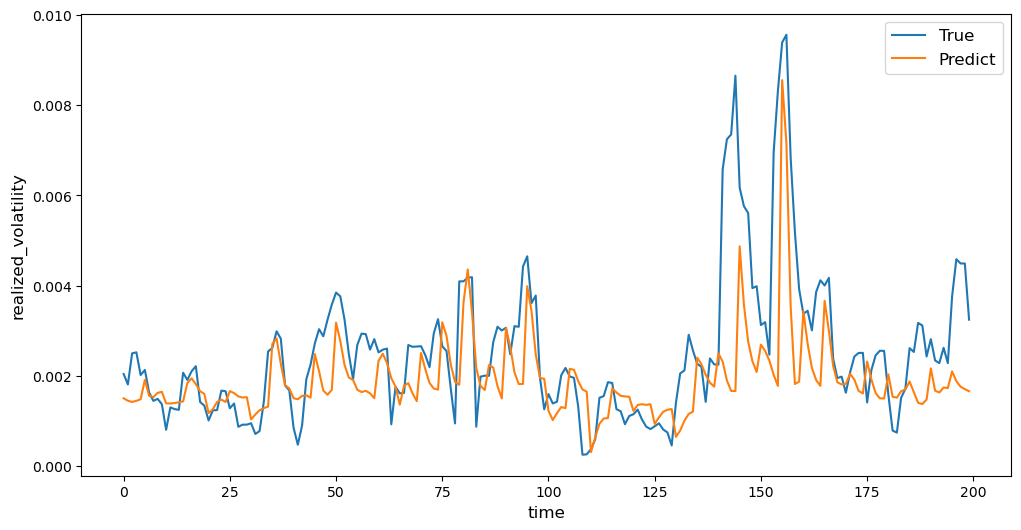

In [37]:
# 假设 labels 和 predictions 是包含所有数据的列表或数组
# 只展示前200条数据
n = 200
labels_subset = labels[-n:]
predictions_subset = predictions[-n:]

plt.figure(figsize=(12, 6))
plt.xlabel('time', fontsize=12)
plt.ylabel('realized_volatility', fontsize=12)
plt.plot(labels_subset, label='True')
plt.plot(predictions_subset, label='Predict')
plt.legend(fontsize=12)
plt.show()